In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist, cifar10
import numpy as np
from PIL import Image
import argparse
import math

import tensorflow as tf

from keras import backend as K
K.set_image_dim_ordering('th')

def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*8*8))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((128, 8, 8), input_shape=(128*8*8,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Convolution2D(3, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(64, 5, 5, border_mode='same', input_shape=(3, 32, 32)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, 5, 5))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model


def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model


def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1], 3), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = np.rollaxis(img, 0, 3)
    return image


def train(BATCH_SIZE):
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    #X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
    discriminator = discriminator_model()
    generator = generator_model()
    discriminator_on_generator = generator_containing_discriminator(generator, discriminator)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    generator.compile(loss='binary_crossentropy', optimizer="SGD")
    discriminator_on_generator.compile(loss='binary_crossentropy', optimizer=g_optim)
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, 100))
    
    K.get_session().run(tf.global_variables_initializer())
    
    for epoch in range(100):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                #iamge = image*255
                Image.fromarray(image.astype(np.uint8)).save('./output/'+str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)
            #print("batch %d d_loss : %f" % (index, d_loss))
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            discriminator.trainable = False
            g_loss = discriminator_on_generator.train_on_batch(noise, [1] * BATCH_SIZE)
            discriminator.trainable = True
            #print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                generator.save_weights('./models/generator', True)
                discriminator.save_weights('./models/discriminator', True)


def generate(BATCH_SIZE, nice=False):
    generator = generator_model()
    generator.compile(loss='binary_crossentropy', optimizer="SGD")
    generator.load_weights('./models/generator')
    if nice:
        discriminator = discriminator_model()
        discriminator.compile(loss='binary_crossentropy', optimizer="SGD")
        discriminator.load_weights('./models/discriminator')
        noise = np.zeros((BATCH_SIZE*20, 100))
        for i in range(BATCH_SIZE*20):
            noise[i, :] = np.random.uniform(-1, 1, 100)
        generated_images = generator.predict(noise, verbose=1)
        d_pret = discriminator.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE, 1) + (generated_images.shape[2:]), dtype=np.float32)
        for i in range(int(BATCH_SIZE)):
            idx = int(pre_with_index[i][1])
            nice_images[i, 0, :, :] = generated_images[idx, 0, :, :]
        image = combine_images(nice_images)
    else:
        noise = np.zeros((BATCH_SIZE, 100))
        for i in range(BATCH_SIZE):
            noise[i, :] = np.random.uniform(-1, 1, 100)
        generated_images = generator.predict(noise, verbose=1)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    #Image.fromarray(image.astype(np.uint8)).save("generated_image.png")
    return image.astype(np.uint8)


'''
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", type=str)
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--nice", dest="nice", action="store_true")
    parser.set_defaults(nice=False)
    args = parser.parse_args()
    return args

if __name__ == "__main__":
    args = get_args()
    if args.mode == "train":
        train(BATCH_SIZE=args.batch_size)
    elif args.mode == "generate":
        generate(BATCH_SIZE=args.batch_size, nice=args.nice)
'''

train(BATCH_SIZE=128)

Using TensorFlow backend.


Bilinear!
Bilinear!
('Epoch is', 0)
('Number of batches', 390)
('Epoch is', 1)
('Number of batches', 390)
('Epoch is', 2)
('Number of batches', 390)
('Epoch is', 3)
('Number of batches', 390)
('Epoch is', 4)
('Number of batches', 390)
('Epoch is', 5)
('Number of batches', 390)
('Epoch is', 6)
('Number of batches', 390)
('Epoch is', 7)
('Number of batches', 390)
('Epoch is', 8)
('Number of batches', 390)
('Epoch is', 9)
('Number of batches', 390)
('Epoch is', 10)
('Number of batches', 390)
('Epoch is', 11)
('Number of batches', 390)
('Epoch is', 12)
('Number of batches', 390)
('Epoch is', 13)
('Number of batches', 390)
('Epoch is', 14)
('Number of batches', 390)
('Epoch is', 15)
('Number of batches', 390)
('Epoch is', 16)
('Number of batches', 390)
('Epoch is', 17)
('Number of batches', 390)
('Epoch is', 18)
('Number of batches', 390)
('Epoch is', 19)
('Number of batches', 390)
('Epoch is', 20)
('Number of batches', 390)
('Epoch is', 21)
('Number of batches', 390)
('Epoch is', 22)
('Num

Bilinear!
Bilinear!
2560/2560 [==============================] - 0s     


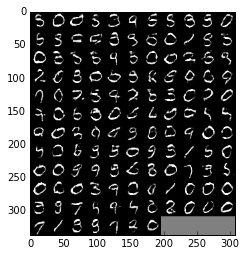

In [9]:
gen_images = generate(BATCH_SIZE=128, nice=True)
plt.imshow(gen_images, cmap='gray')